In [1]:
%matplotlib inline

import os, math
from IPython.display import Image
import numpy as np
seed = np.random.seed

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lab04lib import *

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#Testing data points: 20
Class labels: [-1  1]


In [2]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [3]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, batch_size=1, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state : seed(random_state)
    
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        print("fit with batch_size= {}".format(self.batch_size))
        # run through whole dataset for n_iter times
        for i in range(self.n_iter):
#                 print("Run epoch {}".format(i+1))
                if self.shuffle:
                    X, y = self._shuffle(X, y)
                cost = []
                X_len = len(X)
                batch = int(X_len/self.batch_size)
                cost = []
                for b in range(batch):
#                     print("Run batch[{}/{}]".format(b+1, batch))
                    sub_end = (b+1)*self.batch_size
                    if sub_end > (X_len):
                        sub_end = X_len
                    elif sub_end == X_len:
                        break
                    subX = X[(b*self.batch_size):sub_end,:]
                    suby = y[(b*self.batch_size):sub_end]
                    
                    # train on each batch
                    for xi, yi in zip(subX, suby):
                        cost.append(self._update_weights(xi, yi))
                        
                # record each epcoh's(runthrough whole data) cost
                avg_cost = sum(cost) / len(y)
                self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        
        # Cost function
        error = (yi - output)
        cost = 0.5 * error**2
        
        # Update rule
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        cost = []
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
                
        else:
            s_X = X[0,:]
            s_y = y[0]
            self._update_weights(s_X, s_y)
        return self

fit with batch_size= 1
fit with batch_size= 20
fit with batch_size= 40


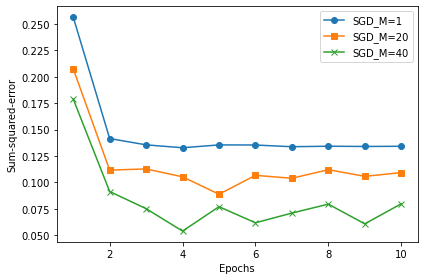

batch(M) = 1
Misclassified samples: 3
Accuracy: 0.85
batch(M) = 20
Misclassified samples: 3
Accuracy: 0.85
batch(M) = 40
Misclassified samples: 3
Accuracy: 0.85


In [10]:
# Fit with different M
adas = []
adas.append(AdalineSGD(n_iter=10, eta=0.01, batch_size = 1, random_state=1))
for a in range(2):
    adas.append(AdalineSGD(n_iter=10, eta=0.01, batch_size = (a+1)*20, random_state=1))
    
for a in range(3):
    adas[a].fit(X_train_std, y_train)


# Cost values
plt.plot(range(1, len(adas[0].cost_) + 1), adas[0].cost_, 
             marker='o', label='SGD_M=1')
plt.plot(range(1, len(adas[1].cost_) + 1), adas[1].cost_, 
             marker='s', label='SGD_M=20')
plt.plot(range(1, len(adas[2].cost_) + 1), adas[2].cost_, 
             marker='x', label='SGD_M=40')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-cost.png', dpi=300)
plt.show()

# Testing accuracy
for a in range(3):
    y_pred = adas[a].predict(X_test_std)
    if a == 0 :
        print('batch(M) = 1') 
    else:
        print('batch(M) = %d' % ((a)*20) )
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


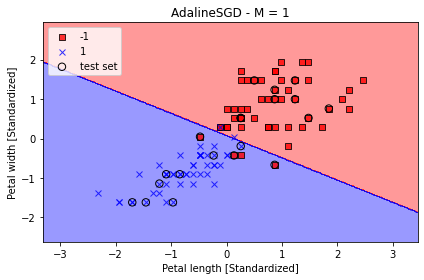

batch(M) = 1
Misclassified samples: 3
Accuracy: 0.85


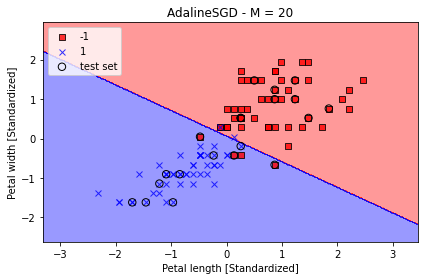

batch(M) = 20
Misclassified samples: 3
Accuracy: 0.85


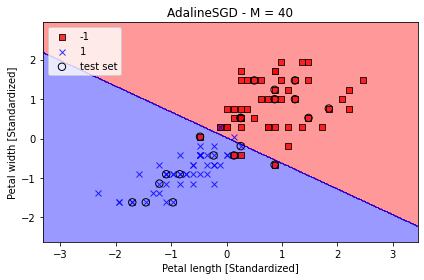

batch(M) = 40
Misclassified samples: 3
Accuracy: 0.85


In [13]:
# plot 2D
def plot_2D(classifier, M):
    X_combined_std = np.vstack((X_train_std, X_test_std))
    y_combined = np.hstack((y_train, y_test))
    
    plot_decision_regions(X_combined_std, y_combined, 
                          classifier=classifier, test_idx=range(len(y_train),
                                                          len(y_train) + len(y_test)))
    plt.title('AdalineSGD - M = '+str(M))
    plt.xlabel('Petal length [Standardized]')
    plt.ylabel('Petal width [Standardized]')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('./output/fig-adaline-sgd-boundary'+'AdalineSGD_M'+str(M)+'.png', dpi=300)
    plt.show()
    
for a in range(3):
    y_pred = adas[a].predict(X_test_std)
    if a == 0 :
        plot_2D(adas[a],1)
        print('batch(M) = 1') 
    else:
        plot_2D(adas[a], a*20)
        print('batch(M) = %d' % ((a)*20) )
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
